In [1]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

In [2]:
vocab_size = 256  # ascii size
x_ = list(map(ord, "hello"))  # convert to list of ascii codes
y_ = list(map(ord, "hola"))   # convert to list of ascii codes
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [3]:
x = Variable(th.LongTensor(x_))
y = Variable(th.LongTensor(y_))

In [4]:
print(x)

tensor([ 104,  101,  108,  108,  111])


In [12]:
'''
Model using GRU and conventional concatenating motion.
'''
class Seq2Seq_GRU(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq_GRU, self).__init__()

        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size * 2, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # Encoder inputs and states
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        outputs = []

        decoder_state = encoder_state
        for i in range(targets.size()[0]): 
            decoder_input = self.embedding(targets)[i].view(1,-1, self.hidden_size)
            decoder_input = th.cat((decoder_input, encoder_state), 2)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            projection = self.project(decoder_output)#.unsqueeze(0))
            outputs.append(projection)
            
            #_, top_i = prediction.data.topk(1)
            
        outputs = th.stack(outputs, 1).squeeze()

        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return Variable(weight.new(self.n_layers, batch_size, self.hidden_size).zero_()) 



In [13]:
model = Seq2Seq_GRU(vocab_size, 16)
pred = model(x, y)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
y_.append(3)
y_label = Variable(th.LongTensor(y_[1:]))

In [15]:
print(y_label.shape)
print(y_label)

torch.Size([4])
tensor([ 111,  108,   97,    3])


In [29]:
log = []
for i in range(10000):
    prediction = model(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data[0]
    log.append(loss_val)
    if i % 100 == 0:
        print("%d loss: %s" % (i, loss_val))
        _, top1 = prediction.data.topk(1, 1)
        for c in top1.squeeze().numpy().tolist():
            print(chr(c), end=" ")
        print()

/Users/sangjunyum/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0 loss: tensor(9.8896)
o l a  
100 loss: tensor(1.00000e-02 *
       5.8784)
h o l a 
200 loss: tensor(1.00000e-02 *
       2.5069)
h o l a 
300 loss: tensor(1.00000e-02 *
       1.7165)
h o l a 
400 loss: tensor(1.00000e-02 *
       1.3201)
h o l a 
500 loss: tensor(1.00000e-02 *
       1.0703)
h o l a 
600 loss: tensor(1.00000e-03 *
       8.9372)
h o l a 
700 loss: tensor(1.00000e-03 *
       7.5901)
h o l a 
800 loss: tensor(1.00000e-03 *
       6.5043)
h o l a 
900 loss: tensor(1.00000e-03 *
       5.6150)
h o l a 
1000 loss: tensor(1.00000e-03 *
       4.8858)
h o l a 
1100 loss: tensor(1.00000e-03 *
       4.2929)
h o l a 
1200 loss: tensor(1.00000e-03 *
       3.8155)
h o l a 
1300 loss: tensor(1.00000e-03 *
       3.4330)
h o l a 
1400 loss: tensor(1.00000e-03 *
       3.1181)
h o l a 
1500 loss: tensor(1.00000e-03 *
       2.8503)
h o l a 
1600 loss: tensor(1.00000e-03 *
       2.6270)
h o l a 
1700 loss: tensor(1.00000e-03 *
       2.4303)
h o l a 
1800 loss: tensor(1.00000

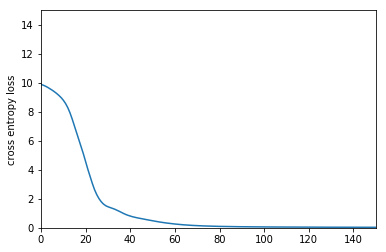

In [52]:
import matplotlib.pyplot as plt
plt.plot(log)
plt.xlim(0,150)
plt.ylim(0,15)
plt.ylabel('cross entropy loss')
plt.show()


In [27]:
# l = nn.CrossEntropyLoss()
# i = th.randn(3, 5, requires_grad=True)
# t = th.empty(3, dtype=th.long).random_(5)
# print(i.shape, t.shape)
# o = l(i, t)

torch.Size([3, 5]) torch.Size([3])
